# Phd-teach-PhD: Approaching science with AI

**An introduction to scientific machine learning**

Guilherme Zagatti      
PhD candidate, NUS ISEP/IDS   
<gzagatti@u.nus.edu>   

# Outline

1. Motivation

    Dynamical systems describe changes we observe

2. Julia

    Intro to the language and ecosystem
    
3. A formal introduction to ODEs and SciML

    The initial value problem
        
    Fitting data to ODEs, classical approaches
    
4. NeuralODE

    The initial value problem reviewed
    
5. Exercises

6. References

# Motivation

**Dynamical systems describe changes we observe**

## "It is then by cause that we define time" (Poincaré 1903)

How do we learn about cause and effect if not by how we observe things evolving? 

**Dynamical systems** are an evolution rule that defines a trajectory as a map (Meiss 2007):

<br/>

$$
    \text{time} ↦ \text{set of states}
$$

<br/>

As a mathematics discipline, the study of dynamical systems originates at the end of 19th century spearheaded by [Henri Poincaré](https://plato.stanford.edu/entries/poincare/) who also developed an extensive theory of sciences.

## Physics: coupled oscillator

Describes the movement of an object with **mass $m$ attached to a spring under force $F$**.

The force follows **Hooke's law**, that is, it is proportional to the initial displacement.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/mass-spring.png" style="height: 250px;">
</div>
<div style="display: flex; align-items: center;">
$$
F = ma \Rightarrow
\frac{d^2 x}{dt^2} =-\frac{kx}{m}
$$
</div>
</div>

## Ecology: Lotka-Volterra

Describes the **dynamics of two-competing species**, the prey $x$ and predator $y$. Predator and prey come in contact to one another according to the proportion of each specie in the environment.

The prey is born with rate $\alpha$. The predator kills the prey with rate $\beta$. 

The predator needs to eat the prey to reproduce at rate $\delta$. The predator dies of natural cause at rate $\gamma$.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/fox-rabbit.png" style="height: 200px;">
</div>
<div style="display: flex; align-items: center;">
$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} & = \delta xy - \gamma y
\end{aligned}
$$
</div>
</div>

## Epidemiology: SIR

Susceptible-infected-recovered: describes the **evolution of an infectious disease**. 

Susceptible and infected individuals come in contact to one another according to the proportion of each type in the population. The disease is then transmitted with rate $\beta$. An infected person recovers with rate $\gamma$.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/sneeze.png" style="width: 250px">
</div>
<div style="display: flex; align-items: center;">
$$
\begin{aligned}
\frac{ds}{dt} &= - \beta si \\
\frac{di}{dt} & = \beta si - \gamma i \\
\frac{dr}{dt} &= \gamma i
\end{aligned}
$$
</div>
</div>

## Economics: Solow growth model

The production function $f(\cdot)$ describes **economic growth as a function of capital $k$**. 

The rate of capital growth is constrained by the savings rate $s$ and the depreciation rate of capital $\delta$. 

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/growth.png" style="width: 250px;">
</div>
<div style="display: flex; align-items: center;">
$$
\frac{dk}{dt} = s f(k) - \delta k
$$
</div>
</div>

## A common thread

All of the presented models describe how the **variables of interest** change as a **function of time** given a set of parameters which are held fix.

Let our variables of interest be $ u = (u_1 \;  u_2 \;  \dots \;  x_N) \in \mathbb{R}^N$ and the law of motion $f: \mathbb{R}^N ↦ \mathbb{R}^N $.

We can express any **generic model** as a system of Ordinary Differential Equations (ODEs):

$$
\dot{u} = \frac{d u}{dt} = f(u)
$$

A key problem is whether any such models have a **unique solution**, that is:

> If we are given an initial set of parameters and an initial condition can we determine the state of the system at any point in the future?

## What is in a function?

Notice that we placed **no restrictions on $f(\cdot)$**. So, it could really be anything.

> In practical terms, can we develop a method that is able to list every possible way in which an element from a set $U$ can be mapped to a single element of a set $V$?

If set $U$ and $V$ are small we can simply list all possible functions $K$:

<div style="display: flex;">
<div style="flex: 0 0 50%; align-items: center; margin-right: 10px;">
$$
\vdots \\
f_k(u) = \begin{cases}
D \text{, if } u = 1 \\
C \text{, if } u \in \{2, 3\}
\end{cases} \\
\vdots
$$
</div>
<div style="flex: 0 0 50%; align-items: center">
<img src="./assets/injection.svg" style="width: 150px;">
</div>
</div>

However, **this does not scale**. Most spaces are continuous and infinite.

## Linear models

We can consider additional strategies. 

For instance, we can restrict ourselves only to **linear functions**, when variables change in proportion to the current state.

$$
\dot{u} = f(u) = A u = \sum_{1 \leq k \leq N} \xi_k \theta_k(u) 
$$

where $\theta_k(u) = u_k$.

The simple harmonic oscillator presented in the beginning is a member of this class of functions.

Again, this is **very restricitve**. 

## Classical function generators

There are other alternatives, we could have the class of **polynomial functions**. 

We know from [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem#Generalizations_of_Taylor's_theorem) that a $k$-times differentiable function $f$ can be approximated with a Polynomial of $k$ degrees. In one dimension, we have:

$$
\dot{u} = f(u_0) + \sum_{k \in \mathbb{N}_+} \frac{d^k f}{du^k}(u_0) \frac{(u - u_0)^k}{k!} = \sum_{k \in \mathbb{N}} \xi_k \theta_k(u)
$$

where $\theta_k(u) = u^k$.

The advantage of Taylor series is that we can **describe $f(\cdot)$ according to its derivatives** --- that is, the way it changes in a small neighborhood.

When $k = 1$, we can approximate the function with a linear function.


## Cyclical decompositions

Alternatively, we can generate any [square-integrable functions](https://en.wikipedia.org/wiki/Square-integrable_function) --- that is, functions with a finite norm --- using the [Fourier series](https://en.wikipedia.org/wiki/Fourier_series):

$$
\dot{u} = \sum_{k \in \mathbb{Z}} \langle f, \theta_k \rangle \, \theta_k(u) = \sum_{k \in \mathbb{Z}} \xi_k \theta_k (u)
$$

where $\langle \cdot \, , \, \cdot \rangle$ is the inner product of two functions and $\theta_k(u) = e^{iku}$.

The Fourier series allow us to describe **changes in terms of cycles**.

The lower the $k$, the lower the frequency of the cycle.

## Basis functions

Ok, so now that we have at least three general methods for generating arbitrary functions that respect different but general assumptions.

**It should be easy to discover laws from data**.

Let our **observations** $X$, the dictionary of **basis functions** $\Theta(\cdot)$ and the **coefficient matrix** $\Xi$: 

$$
X = \begin{pmatrix}
& \dots &  \\ 
& x(t)^\top & \\
& \dots &
\end{pmatrix}
\,\text{,}\quad
\Theta (\cdot) = \begin{pmatrix}
\vdots & \vdots & \vdots & \vdots \\ 
1 & \theta_1(\cdot) & \dots & \theta_K(\cdot) \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}
\,\text{,}\quad
\Xi (\cdot) = \begin{pmatrix}
\vdots & \vdots & \vdots & \vdots \\ 
\xi_0 & \xi_1 & \dots & \xi_N \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}
$$

In many cases, the number of basis function $K$ is proportional to the maximum dimension $D$ of the basis functions, such that $K \propto D^N$ 

The dynamical problem can thus be **reformulated** as:

$$
\underbrace{\dot{X}}_{\scriptscriptstyle{T \times N}} = \underbrace{\Theta(X)}_{\scriptscriptstyle{T \times K}} \, \underbrace{\Xi}_{\scriptscriptstyle{K \times N}}
$$

## Sparse Identification of Nonlinear Dynamics (SINDy)

A linear regression can help us to find the parameters that best fit the data. Add some regularization parameters to optimize sparsity:

$$
\hat{\Xi} = \underset{\mathrm{\Xi}}{argmin} \, || \dot{X} - \Theta(X) \, \Xi ||_2 + \lambda || \Xi ||_1
$$

In **theory**, if $T >> K N$, our system is identifiable.

In **practice**, there are number of problems:

1. Numerical errors in the computation of $\dot{X}$

2. The number of states $N$ might be prohibitively large

3. Curse of dimensionality: number of basis functions grows arbitrarily large as $D^N$

See **Brunton (2016)** for more details.

## From generic functions to black boxes

Besides dictionary methods, are there other ways?

This is where **neural networks (NN)** enter the picture --- arguments are borrowed from [Chris Rackauckas](https://mitmath.github.io/18337/lecture3/sciml.html):

1. the **Universal Approximation Theorem (UAT)** states that NN can approximate most well-behaved functions with any degree of precision which is controlled by the depth of the network (see Kratsios 2021);

2. **NN overcome the curse of dimensionality**, the approximation of a function of dimension $D$ only needs a polynomial number of parameters $D^C$ rather than $D^N$ where $C$ is a constant (see Grohs 2019);

3. NN allows the **enforcement of many arbitrary constraints** via activation functions;

4. **NN are isotropic**, they are naturally non-aligned to a basis;

5. local optimization of NN are **more likely to reach global minimum** (see Lacotte 2020)




## Why don't we just approximate x(t) with NN?

At the end of the day, NN are universal approximators and most of the arguments should apply when approximating:

$$
u = u(t; u_0) \approx NN(t; u_0)
$$

Most ODE problems do not have **analytical solution** and **are naturally expressed in terms of rates of change**.

We build from previous knowledge, NN are only used to describe the **unknown dynamics of our model**

"*...the well-known adage "a picture is worth a thousand words" might well be "a model is worth a thousand datasets"*"<br/>
Rackauckas 2020

## What about stochastic models?


<div style="display: flex; align-items: center;">
<div style="flex: 0 0 250px; align-items: center; margin-right: 10px; ">
<img src="./assets/coin-flip.png">
</div>
<div>
<p>Many scientific problems are expressed in terms of <b>random events</b>.
<p>The <a href="https://www.youtube.com/watch?v=AYnJv68T3MM">flip of a coin</a> can be modelled as a complex dynamical system or as a simple Bernouilli distribution.
<p>Although there are distinct basins of attraction --- more on that later ---, <b>sensitivity to and uncertainty about initial conditions</b> means that the motion can be described as a random process in practice (Diaconis 2007, Strzałko 2008).
<p>However, in <b>complex scenarios</b> the description of attractors and the distribution of initial states is not easy to observe.
<p>Tools to analyse <b>ODE systems</b> allow us to describe and characterize basins of attraction and the attractors themselves.
</div>
</div>

## Describing nature with models

<p>"*It is not sufficient for each elementary phenomenon to obey simple laws, all those to be combined must obey the same law as well.*"<br/>Poincaré 1902

A lot ingenuity and observation is required to develop models that are both **consistent with reality and existing theory**.

Scientific machine learning is a **set of tools for automated model discovery** to support the development of models from data.
    
<div style="display: flex;">
<div style="flex: 0 0 250px;">
<img src="./assets/khun.png" style="height: 150px;">
</div>
<div style="display: flex; align-items: center;">
<p>According to Thomas Khun, science is a combination of <b>marginal revolutions and paradigm shifts</b>.
</div>
</div>

# Julia

**Into to the language and ecosystem**

## The <img src="./assets/julia-logo.svg" style="display: inline; vertical-align: text-top; width: 36pt; "></img> programming language

**Fast** designed for high-performance, just-in-time (JIT) compiled code.

**Reproducible environment** `Project.toml` and `Manifest.toml`, such as the ones in this course, contains all the instructions to reproduce the environment.

**General** from data-wrangling through data-analytics to data-reporting.

**Dynamic**, feels like Python.

**Composable**, not quite like Python. Multiple dispatch as a paradigm and functional programming.

**Open source** MIT license and active developer community in the scientific machine learning field.

Visit [Julia's](https://julialang.org) website to get started. 

Check [Julia discourse](https://discourse.julialang.org/) to look for help, a lot of community interaction takes place in there.

## The quality of the language is reflected in the quality of packages

No other language can achieve the combination of **performance**, **mathematical notation** and **composition** that Julia provides:

* Differential Equations: [DifferentialEquations.jl](https://diffeq.sciml.ai/)

* Function approximation and manipulation: [JuMP.jl](https://jump.dev/), [ApproxFun.jl](https://juliaapproximation.github.io/ApproxFun.jl/)

* Interval constraint programming and rigorous root finding: [IntervalRootFinding](https://juliaintervals.github.io/pages/packages/intervalrootfinding/)

* GPUs: [CuArrays.jl](https://juliagpu.org/cuda/)

* Linear algebra for large-systems:[BlockBandedMatrices.jl](https://juliamatrices.github.io/BlockBandedMatrices.jl/stable/), [InfiniteLinearAlgebra.jl](https://github.com/JuliaMatrices/InfiniteLinearAlgebra.jl)

* Automatic differentiation: [Zygote.jl](https://fluxml.ai/Zygote.jl/), [ForwarDiff.jl](https://juliadiff.org/ForwardDiff.jl/)

* Neural networks: [Flux.jl](https://github.com/FluxML/Flux.jl)

On top of that, **most of Julia is written in Julia**. No C, C++ or Fortran, just Julia.


## Installation

To follow the course, make sure to install the latest stable version of `Julia` from its [official page](https://julialang.org/downloads/). 

Then, clone this repository:

```
> git clone git@github.com:gzagatti/phdteachphd-sciml.git
```

After downloading the repository, activate its Julia environment and install its dependencies:

```
> cd phdteachphd-sciml/
> julia
               _
   _       _ _(_)_     |  Documentation: https://docs.julialang.org
  (_)     | (_) (_)    |
   _ _   _| |_  __ _   |  Type "?" for help, "]?" for Pkg help.
  | | | | | | |/ _` |  |
  | | |_| | | | (_| |  |  Version 1.6.1 (2021-04-23)
 _/ |\__'_|_|_|\__'_|  |  Official https://julialang.org/ release
|__/                   |

julia> ]
(@v1.6) pkg> activate .
  Activating environment at `./phdteachphd-sciml/Project.toml`
(@v1.6) pkg> instantiate
  Resolving package versions...
  ...
```


## Interacting with Julia

<div style="display: flex; align-items: center;">
<div style="display: flex; margin-right: 10px;">
<ol>
<li>as a scripting language <pre><code>> julia my-code.jl</code></pre></li>
<li>from the terminal using the built-in REPL <pre><code>julia> 1 + 1</code></pre></li>
<li>from a Jupyter notebook using <code>IJulia</code> <pre><code>julia> using IJulia; jupyterlab();</code></pre></li>
<li>from <a href="https://www.julia-vscode.org/">Julia for VSCode</a> a powerful IDE for interactive computing similar to Rstudio, check <a href="https://www.youtube.com/watch?v=IdhnP00Y1Ks">its presentation</a> for more details.</li>
</ol>
</div>
<div style="flex: 0 0 350px;">
<img src="./assets/vscode.png" style="width: 350px;">
</div>
</div>

## Paralellism

Ensure that Julia is started with **multi-thread support** to take advantage of this feature, either:

* modify the environment `export JULIA_NUM_THREADS=4` before starting `julia` or `jupyter lab` --- in case you are using Jupyter notebook
* use the flag `-t` when starting Julia, `julia -t 4`

In [1]:
using Base.Threads
Threads.nthreads()

4

## Ecosystem

Julia comes with a built-in package manager, which means it is much easier to manage dependencies and avoid duplicating cached pre-compiled libraries.

Check for packages in [Julia Packages](https://juliapackages.com/) or in [JuliaHub](https://juliahub.com/ui/Packages). Learn more about the community behind Julia Packages by browsing [Julia GitHub Groups](https://julialang.org/community/organizations/).

All Julia configuration and installed packages are installed in `~/.julia`.

From the CLI, the package manager can be accessed by typing `]`

```
julia> ]
(@v1.6) pkg> activate MyPackage # activate the environment described in MyPackage
(@v1.6) pkg> add ExternalPackage # add external packages
(@v1.6) pkg> status # check the status of packages installed in the environment
```

Alternatively, use the `Package` module.

In [81]:
import Pkg
Pkg.DEFAULT_IO[] = stdout # only needed in Jupyter, before v1.6.2 comes out
Pkg.status()

     Project PhDTeachPhD v0.1.0
      Status `~/phd/phdteachphd-sciml/Project.toml`
  [6e4b80f9] BenchmarkTools v1.0.0
  [aae7a2af] DiffEqFlux v1.37.0
  [0c46a032] DifferentialEquations v6.17.1
  [6a86dc24] FiniteDiff v2.8.0
  [587475ba] Flux v0.12.4
  [f6369f11] ForwardDiff v0.10.18
  [7073ff75] IJulia v1.23.2
  [429524aa] Optim v1.3.0
  [91a5bcdd] Plots v1.16.5
  [37e2e46d] LinearAlgebra


## The anatomy of a package

Modules are usually packaged as following.

```
MyFirstModule.jl
├── docs/
│   ├── src/
│   ├── Project.toml
│   └── make.jl
├── src/
│   ├── MyFirstModule.jl
│   └── ...
├── test/
│   ├── runtests.jl
│   └── ...
├── Project.toml
├── Manifest.toml
└── README.md
```

When looking at source code, a good idea is to start from `src/MyFirstModule.jl` to understand **what are the dependencies**, **which files are included** and **which names are exported**.

To learn more about packages, check [Chris Rackauckas video](https://www.youtube.com/watch?v=-lJK92bEKow).

## The anatomy of a module

Modules help to organize code into coherent units.

Although rarely done, we can also define the module in the current scope as done here for teaching purposes.

In [3]:
module MyFirstModule

# we can import functions defined elsewhere, they will be bound to the module's scope
using Statistics

# adds code from other files, this how you put everything together in your module
include("example.jl")

# we can also define functions and constants in the declaration file, but this is less common
const MyFirstConstant = 42

function random_average(n)
    mean(rand(n))
end

# functions and constants can be exported
export MyFirstConstant, hello, random_average

end;

## Using modules

There are two ways of adding modules to the local scope.

Either with `using`, in which case all names that are exported from the module are added to the local namespace.

In [4]:
using Statistics

mean(rand(10))

0.41226147834060123

Or with `import`, in which case only the module name is brought into scope. Users need to prepend the module name to access its definitions.

In [5]:
# we append `Main` as the module is defined in the current scope
import Main.MyFirstModule

println("""
$(MyFirstModule.hello("class"))
What's the meaning of life? $(MyFirstModule.MyFirstConstant). 
Tell me joke: $(MyFirstModule.random_average(10)).
""")

Hello, class!
What's the meaning of life? 42. 
Tell me joke: 0.46651402590700297.



## Looking for help

Don't forget Julia is about multiple dispatching.

In [6]:
? MyFirstModule.hello

```
hello(world)
```

Prints a welcome message.


In [7]:
MyFirstModule.hello(2)

"Hello, don't be fooled 4!"

In [8]:
@which MyFirstModule.hello(2)

hello(n::Number) in Main.MyFirstModule at /home/gzagatti/phd/phdteachphd-sciml/docs/example.jl:8

In [9]:
methods(MyFirstModule.hello)

# 2 methods for generic function "hello":
[1] hello(n::Number) in Main.MyFirstModule at /home/gzagatti/phd/phdteachphd-sciml/docs/example.jl:8
[2] hello(world) in Main.MyFirstModule at /home/gzagatti/phd/phdteachphd-sciml/docs/example.jl:6

In [83]:
# will print the file where the called function is declared
# see @edit alternatively
@less MyFirstModule.hello("class")

"""
    hello(world)

Prints a welcome message.
"""
hello(world) = "Hello, $(world)!"

hello(n::Number) = "Hello, don't be fooled $(n*2)!"


## Arrays

In [84]:
b = [
    1
    2
    3
] # column vector

3-element Vector{Int64}:
 1
 2
 3

In [85]:
b = [1; 2; 3] # to avoid line breaks you can use `;`

3-element Vector{Int64}:
 1
 2
 3

In [13]:
b[1] # the index start at 1

1

In [14]:
b[0] # this will not work

LoadError: BoundsError: attempt to access 5-element Vector{Int64} at index [0]

In [86]:
b = Vector{Float64}(undef, 3) # initialize a vector with 3 elements
b[1] = b[2] = b[3] = 5
b

3-element Vector{Float64}:
 5.0
 5.0
 5.0

In [16]:
b = [1 2 3 4 5] # row vector, row vectors considered matrices

1×5 Matrix{Int64}:
 1  2  3  4  5

In [17]:
a = similar(b) # we can start a vector of the same type as b with undefined values

1×5 Matrix{Int64}:
 0  1  140294007968512  4  1

In [18]:
A = [
    1 1 1 1 1
    2 2 2 2 2
    3 3 3 3 3
    4 4 4 4 4
    5 5 5 5 5
] # define a matrix

5×5 Matrix{Int64}:
 1  1  1  1  1
 2  2  2  2  2
 3  3  3  3  3
 4  4  4  4  4
 5  5  5  5  5

In [19]:
A[2, 3] = 7 # change element of matrix

7

In [20]:
A[4, 5] = 7.2 # we cannot insert Floats to an integer matrix 

LoadError: InexactError: Int64(7.2)

In [21]:
A = Matrix{Float64}(undef, 5, 5) # another way to initialize a matrix

5×5 Matrix{Float64}:
 6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310
 6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310
 6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310
 6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310
 6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310  6.93137e-310

In [22]:
A[:] = rand(5, 5)

5×5 Matrix{Float64}:
 0.471852  0.00901112   0.817024  0.541949   0.38184
 0.367064  0.113517     0.572653  0.164718   0.289108
 0.597985  0.0417505    0.796713  0.217953   0.161311
 0.554584  0.112756     0.260227  0.0406933  0.550129
 0.722082  0.000207122  0.864368  0.740878   0.360224

In [23]:
a = @view A[4, :] # create a pointer to the 4th row

5-element view(::Matrix{Float64}, 4, :) with eltype Float64:
 0.5545837167079448
 0.11275579041769235
 0.2602273328162765
 0.040693320492557694
 0.5501291545569911

In [24]:
a[1:5] = repeat([1.], 5) # modifications to the pointer will modify the array
A

5×5 Matrix{Float64}:
 0.471852  0.00901112   0.817024  0.541949  0.38184
 0.367064  0.113517     0.572653  0.164718  0.289108
 0.597985  0.0417505    0.796713  0.217953  0.161311
 1.0       1.0          1.0       1.0       1.0
 0.722082  0.000207122  0.864368  0.740878  0.360224

In [25]:
v = Vector{Vector{Any}}(undef, 3) # we can also have array of arrays
v[1] = [4, 5]
v[2] = [5., 7., 9.]
v[3] = rand(1)
v

3-element Vector{Vector{Any}}:
 [4, 5]
 [5.0, 7.0, 9.0]
 [0.1648178569034804]

## Operations on arrays

In [26]:
map((x) -> x^2, b) # broadcast a function to all elements in b

1×5 Matrix{Int64}:
 1  4  9  16  25

In [27]:
broadcast(^, b, 2) # we can achieve the same result with the broadcast operator

1×5 Matrix{Int64}:
 1  4  9  16  25

In [28]:
b.^2 # the dot operator in front of many functions is a shorthand for the broadcast function

1×5 Matrix{Int64}:
 1  4  9  16  25

In [29]:
A*b' # matrix multiplication, notice the `'` operator which indicates the adjoint

5×1 Matrix{Float64}:
  7.017939857726915
  4.4164641441774535
  4.749990821829545
 15.0
  8.080231257941143

In [30]:
A.*b # broadcast multiplication

5×5 Matrix{Float64}:
 0.471852  0.0180222    2.45107  2.16779   1.9092
 0.367064  0.227033     1.71796  0.65887   1.44554
 0.597985  0.0835011    2.39014  0.871812  0.806553
 1.0       2.0          3.0      4.0       5.0
 0.722082  0.000414243  2.5931   2.96351   1.80112

In [31]:
b .= 2 # assignments can also be broadcast

1×5 Matrix{Int64}:
 2  2  2  2  2

In [32]:
b[:] = 2 # notice that this won't work

LoadError: ArgumentError: indexed assignment with a single value to many locations is not supported; perhaps use broadcasting `.=` instead?

In [87]:
b = 2; # and this simply allocates the integer 2 to variable b

## Control flow

This is very similar to other languages.

In [88]:
for i=1:2
    @show i
end

b = 10
while b >= 7
    println("this is b = $(b)")
    b -= 1
end

if b > 7
    print("Too high.")
else
    print("Too low.")
end

i = 1
i = 2
this is b = 10
this is b = 9
this is b = 8
this is b = 7
Too low.

Note that variables defined inside of loops and branches are not available in the calling scope.

In [35]:
for i = 1:2
    t = "i only exist inside of the loop."
    println(t)
    break
end
@show t

i only exist inside of the loop.


LoadError: UndefVarError: t not defined

This also aplies to the iterator.

In [36]:
@show i

LoadError: UndefVarError: i not defined

Nested loops are simple.

In [37]:
for i=1:2, j=2:3  print("(i, j) = ($(i), $(j))  ") end

(i, j) = (1, 2)  (i, j) = (1, 3)  (i, j) = (2, 2)  (i, j) = (2, 3)  

## Functions

You can define functions as:

In [38]:
f(x) = 2x^2 + 2x # notice that we don't need the * between 2 and x
f(2)

12

We can quickly take the derivative our new functions.

In [39]:
using ForwardDiff # for automatic differentiation
ForwardDiff.derivative(f, 2.0)

10.0

There are alternative syntaxes for function definition. 

Let's define a function that computes the derivative of our function at any point $x$.

In [40]:
# notice that in Julia we can use unicode variables
# type \delta and press tab to get the character
function δf(x) 
    ForwardDiff.derivative(f, x)   
end
δf(2)

10

Notice that a convention in Julia is to add a bang `!` at the end of functions that modify its parameters. This is a community convention, it is not automatically enforced by the language in any way.

In [41]:
f!(x) = x[2] = 5

f! (generic function with 1 method)

In [42]:
b = [1 1 1 1]
f!(b)
b

1×4 Matrix{Int64}:
 1  5  1  1

## Multiple dispatch

Let's go back to `MyFirstModule.hello`. 

We could overload this function with a method that work slightly different for arrays.

In [43]:
MyFirstModule.hello(x::Array) = join([MyFirstModule.hello(i) for i in x], "\n")
println(MyFirstModule.hello(["Clara", 65, ["John", 10]]))

Hello, Clara!
Hello, don't be fooled 130!
Hello, John!
Hello, don't be fooled 20!


Notice how we were able to perform multiple dispatches even inside the function.

[If not abused](https://docs.julialang.org/en/v1/manual/performance-tips/#The-dangers-of-abusing-multiple-dispatch-(aka,-more-on-types-with-values-as-parameters), the **overhead incurred by multiple dispatch is minimal**, thus Julia is able to handle a large number of multiple types with a single function call.

Good use of multiple dispatch allows you to easily piggback not only on the APIs of [Base Julia](https://docs.julialang.org/en/v1/manual/interfaces/) but also on the large number of good quality packages.


## A note about "vectorization"

The **usual advice in Pythnon is to "vectorize" operations** as much as possible and avoid loops.

This is because vectorized operations call C programs which are optimized for the "vectorized" operation.

On the contrary, **in Julia "vectorization" does not necessarily improve performance**.

In [11]:
N = 1000
A = rand(N, N);
B = rand(N, N);

We will use one of the main benchamrking framework for Julia to compare the performance of snippets of code both in terms of **memory allocation** and **time**.

When in doubt, **this is a quick and effective way to locate bottlenecks** in your code.

In [12]:
using BenchmarkTools

<div style="display: flex; align-items: center;">
<div style="flex: 0 0 250px; margin-right: 10px; width: 250px;">
<img src="./assets/array-order.png" style="width: 250px;">
</div>
<div style="display=flex;">
<p>In Julia arrays are column-major.
<p>Which means that loops over columns are faster than over rows.
</div>
</div>

In [13]:
A[:] # vectorize the matrix, allow us to visualize the array-order;

Row allocation will be slower than column allocation.

In [14]:
function modifyC0!(A, B, C, i)
    C[i, :] .= A[i, :] .* B[i, :]
end
@btime modifyC0!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  14.808 μs (2 allocations: 15.88 KiB)


In [15]:
function modifyC1!(A, B, C, i)
    C[:, i] .= A[:, i] .* B[:, i]
end
@btime modifyC1!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  1.288 μs (2 allocations: 15.88 KiB)


In this case, the row-major loop was about 50 percent slower than the column major one.

We might think that our vectorized call to `.*` in `modifyC1!` is enough to ensure the code runs fast.

But in fact we are making unnecessary allocations. Using `@views` allow us to modify the array directly.

In [21]:
@views function modifyC2!(A, B, C, i)
    C[i, :] .= A[i, :] .* B[i, :]
end
@btime modifyC2!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  15.255 μs (0 allocations: 0 bytes)


In [22]:
@views function modifyC3!(A, B, C, i)
    C[:, i] .= A[:, i] .* B[:, i]
end
@btime modifyC3!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  112.119 ns (0 allocations: 0 bytes)


In [18]:
function modifyC4!(A, B, C, i)
    for j in 1:size(C)[1]
        C[j, i] = A[j, i] * B[j, i]
    end
end
@btime modifyC4!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  872.691 ns (0 allocations: 0 bytes)


In [23]:
function modifyC5!(A, B, C, i)
    @inbounds for j in 1:size(C)[1]
        C[j, i] = A[j, i] * B[j, i]
    end
end
@btime modifyC5!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  89.670 ns (0 allocations: 0 bytes)


In [26]:
using LoopVectorization
@views function modifyC6!(A, B, C, i)
    @turbo C[:, i] .= A[:, i] .* B[:, i]
end
@btime modifyC6!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  64.396 ns (0 allocations: 0 bytes)


## Basic Types

Numbers come in different flavors in Julia.

In [53]:
typeof(1)

Int64

In [54]:
typeof(1.)

Float64

In [55]:
typeof(1 // 1)

Rational{Int64}

In [56]:
typeof(1f0)

Float32

More about numbers in the [documentation](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/)

**Tuples**

In [57]:
b = (5, .2)

(5, 0.2)

As usual, tuples are not modifiable.

In [58]:
b[2] = 4

LoadError: MethodError: no method matching setindex!(::Tuple{Int64, Float64}, ::Int64, ::Int64)

**Dictionaries**

In [59]:
d = Dict(:d => "blue", 1 => "book", "ball" => 2)

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 2
  1      => "book"

In [60]:
d[:d]

"blue"

In [61]:
d["ball"] = 45
d

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 45
  1      => "book"

**Symbols**

Symbols are a way in which the language code can represent itself a data structure. The evaluation of a symbol depends on the scope.

In [62]:
eval(:d)

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 45
  1      => "book"

In [63]:
d[:d]

"blue"

They are useful in metaprogramming, a feature which Julia shares with Lisp. This is an advanced feature briefly covered in the end of this tutorial.

For more details check this [StackOverflow answer](https://stackoverflow.com/questions/23480722/what-is-a-symbol-in-julia).

**Iterators**

In [94]:
a = 1:2

1:2

In [95]:
typeof(a) # iterators are not arrays

UnitRange{Int64}

In [96]:
fieldnames(typeof(a)) # print the fields contained in a type

(:start, :stop)

In [97]:
collect(a) # convert range to vector

2-element Vector{Int64}:
 1
 2

## Types

They come in three flavors.

First, **immutable types**.

In [68]:
struct Point
    x::Float64
    y::Float64
end
a = Point(1., 0.)

Point(1.0, 0.0)

You cannot mutate immutable types.

In [69]:
a.x = 2 

LoadError: setfield! immutable struct of type Point cannot be changed

Second, **mutable types**.

In [98]:
mutable struct MutablePoint
    x::Float64
    y::Float64
end
b = MutablePoint(5., 3.)

MutablePoint(5.0, 3.0)

In [72]:
b.x = 2.
b

MutablePoint(2.0, 3.0)

It is not advisable to create mutable structures unless necessary.

In Julia immutable types are able to be stored closer to the CPU and have less cost of memory access --- they are stack allocate. On the other hand, mutable types are heap allocated.

Third, **abstract types** serve to define a hierarchy.

In [73]:
abstract type AbstractShape end 

In [74]:
struct Square <: AbstractShape
    x::Float64
    y::Float64
    length::Float64
end
Square(5., 5., 2.)

Square(5.0, 5.0, 2.0)

The type of elements inside of types can also be parametrized.

In [75]:
struct Rectangle{T<:Number} <: AbstractShape
    x::T
    y::T
    length::Float64
    height::Float64
end
Rectangle{Int64}(5., 5., 2., 3.)

Rectangle{Int64}(5, 5, 2.0, 3.0)

As always, we can oveload functions in Julia to extend the functionality of our types.

In [76]:
Base.:+(a::Point, b::Point) = Point(a.x + b.x, a.y + b.y)
Point(2., 3.) + Point(4., 5.)

Point(6.0, 8.0)

## Metaprogramming

Throughout this tutorial you might have seen many commands that start with `@`. These are called macros. 

Macro are functions on expressions. It allow us to dynamically write code. In Julia every statement is of type `Expression` so we can build code to build code.

An example is a fancy `@println`.

In [77]:
macro println(s) return :( println($s) ) end

@println (macro with 1 method)

In [78]:
@println "Hello, world!"

Hello, world!


The code takes an expression `s`, which is evaluated with `\$s`. So, if `s` is a string like `"foo"`, it is evaluated to the string `"foo"` itself. 

The call to `println` is enclose in quotes --- `:( )` which is way to create expression objects.

Whenever the macro is called the expression is evaluated. Thus, if we pass `"foo"` it is like we typed in the console: `println("foo")`.

Check the [documentation on metaprogramming](https://docs.julialang.org/en/v1/manual/metaprogramming/) for more details.

## Additional tutorials

There are many additional materials on-line:

- [Julia documentation](https://docs.julialang.org/en/v1/): the official manual (including base libraries).
- [Get started with Julia](https://julialang.org/learning/): official recommendation of courses and books.
- [Learn Julia in Y minutes](https://learnxinyminutes.com/docs/julia/): a quick tutorial for experienced programmers.
- [Julia cheatshet](https://cheatsheets.quantecon.org/julia-cheatsheet.html): quick reference, mostly focused on numerical computation. 
- [Chris Rackauckas intro](https://www.youtube.com/watch?v=-lJK92bEKow): 30-minutes, quick video tutorial.
- [A deep introduction to julia for data science and scientific computing](http://ucidatascienceinitiative.github.io/IntroToJulia/): another Chris Rackauckas's intro with a lot of good insights into Julia for scientific machine learning.
- [Julia MIT](https://github.com/mitmath/julia-mit): simple tutorial on installing and using Julia targeted for MIT students.
- [MIT 18.337J/6.338J](https://github.com/mitmath/18337): full semester course of Julia for scientific machine learning.
- [QuantEcon](https://julia.quantecon.org/index_toc.html): in-depth introduction to quantitative economics with Julia.
- [ThinkJulia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html): in-depth introduction to Julia from a computer science perspectie

# ODEs and SciML

**The initial value problem, classical approaches for fitting data to ODEs**

In the motivation section, we motivated the applications of systems of ODEs in scientific discovery.

We will now:

* formally introduce ODEs and the initial value problem

* discuss computational methods for solving the initial value problem

* fitting data to ODEs

## The initial value problem

Let our variables of interest be $ u = (u_1 \;  u_2 \;  \dots \;  u_N) \in \mathbb{R}^N$ and the law of motion $f: \mathbb{R}^N ↦ \mathbb{R}^N $.

The initial value problem is to **find a solution $u(t; u_0)$** to the system of ODEs:

$$
\dot{u} = \frac{d u}{dt} = f(u)
$$

with initial condition, $(t_0, u_0)$.

**Integrating the differential**, we obtain:

$$
u(t) = u(t_0) + \int_{t_0}^t f(u(t)) dt = u_0 + \int_{t_0}^t f(u(t)) dt
$$

This expression denotes the solution of the system as **the sum of the infinitesimal changes expressed by $f$** starting from $u_0$ to $t$.

However, this expression is a transcendental equation --- $u$ is expressed on both sides. Thus, it it does not constitute of a solution.

## A unique solution

The solution to initial value problem problem **$u(t; u_0)$** is a function that indicates **the state of the system at every point in time given the initial conditions**.

Given the constraints of the problem, the **solution satisfies** the following:

$$
u(t_0; u_0) = u_0 \text{ and } \frac{du}{dt}(t; u_0) = f(u)
$$

If $f$ is uniformly continuous around the initial condition and is Lipschitz on $x$, the [Picard-Lindelöf theorem](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem) guarantees that **the solution $u(t; u_0)$ is unique**, i.e. there is only one function that starts at the initial condition and follows the law of motion.

**Lipschitz continuity** implies that:

$$
|f(u_1) - f(u_2)| \leq K |u_1 - u_2|
$$

which is a stronger form of uniformly continuity and implies that is differentiable almost everywhere --- it excludes points where the derivative is not defined or is infinite.

## Example

We will show how to compute the solution, $u(t; u_0)$ to the **Lotka-Volterra** problem before looking under the hood on how this is done.

In [1]:
using DifferentialEquations # used for solving and analysing ODEs
using Plots # used for plotting

Check the documentation for [DifferentialEquations](https://diffeq.sciml.ai/) and [Plots](https://docs.juliaplots.org/) for additional tutorials and information.

To remind ourselves, the problem is defined as:

$$
\begin{aligned}
\frac{du_1}{dt} &= \alpha u_1 - \beta u_1 u_2 \\
\frac{du_2}{dt} & = \delta u_2 - \gamma u_2
\end{aligned}
$$

The first step is to define the function in Julia. Which looks very similar to the mathematical definition.

In [62]:
"""
    lv!(du, u, p, t)

Updates the diffential `du` at time `t` given state `u` and parameters `p`. 

This function produces side-effects by modifying `du`.
"""
function lv!(du, u, p, t)
    α, β, δ, γ = p
    du[1] = α*u[1]      - β*u[1]*u[2]
    du[2] = δ*u[1]*u[2] - γ*u[2]
end;

We then define the initial parameters, the time interval we are interested and the parameters

In [63]:
# example and parameters from Wikipedia article
# https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
u0 = [1., 1.];
tspan = (0., 100.);
p = [1.1, 0.4, 0.1, 0.4];

The problem is initialized with `ODEProblem` and then solved with `solve`.

The solution contains a lot of useful attributes: 

* the return code --- check if it was successful
* the interpolation method
* the time in which the solution was evaluted
* the state during these periods.

In [64]:
lv_prob = ODEProblem(lv!, u0, tspan, p);
lv_sol = solve(lv_prob)

retcode: Success
Interpolation: automatic order switching interpolation
t: 112-element Vector{Float64}:
   0.0
   0.11320015348637516
   0.4681592909524539
   0.9641102205924529
   1.537121681862952
   2.2228806088322615
   2.9841313355596593
   3.734159692704818
   4.369630694609109
   4.882481662690394
   5.4954355981272744
   6.127449855012929
   6.618793010540405
   ⋮
  89.4934054389658
  91.07684551318968
  92.39747927511443
  93.73316999542666
  95.11807656873233
  95.825854638286
  96.67524758998749
  97.32232786494914
  98.0209989739637
  98.83555693886274
  99.66274959351703
 100.0
u: 112-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.083280099920301, 0.9670583653486702]
 [1.4046490071995235, 0.8766758809132047]
 [2.0572729161989547, 0.7824624879809521]
 [3.2553390397044915, 0.7224612900393564]
 [5.678913287785877, 0.7403641343642866]
 [10.180524605961132, 0.9856149169956617]
 [15.45813754000238, 1.9261460945336448]
 [14.919433592206442, 4.106691344880623]
 [8.96804136080964

We can plot our solution. Remember that our solution is a function of time.

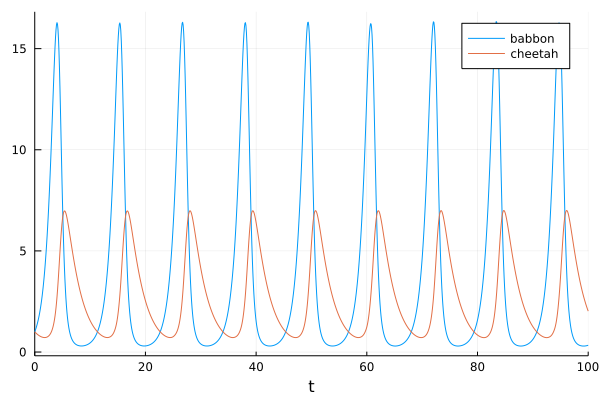

In [65]:
plot(lv_sol, label=["baboon" "cheetah"])

As you can see our solution follows a cyclical pattern, an increase in baboons is followed by an increase in cheetahs.

We can also see our solution in the phase plane, with the `vars` argument. 

This corresponds to eliminating time from our system and looking at dynamics between $u_1$ and $u_2$ as described by the partial differential equation:

$$
\frac{\partial u_1}{\partial u_2} = - \frac{u_2}{u_1} \frac{\delta u_1 - \gamma}{\beta u_2 - \alpha}
$$


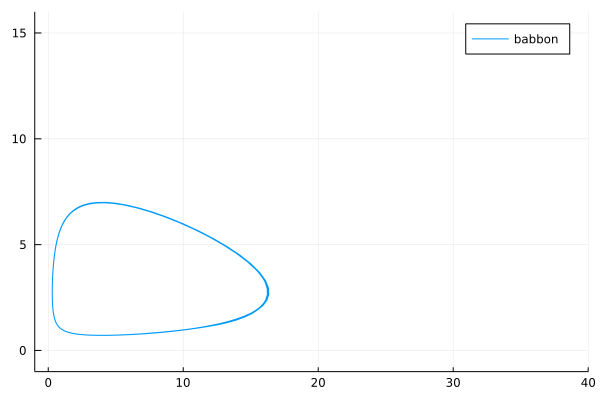

In [73]:
plot(lv_sol, vars=(1, 2), label=["babbon" "cheetah"])
plot!(xlims=(-1, 40), ylims=(-1, 16)) # adjust axis for better viz

We can derive many useful information from the solution object, `lv_sol`.

Get the size of the solution (number of interpolations).

In [74]:
size(lv_sol)

(2, 112)

The inteporlation time and state at interpolation step 10.

In [75]:
lv_sol[10]

2-element Vector{Float64}:
 8.968041360809643
 6.232808496978902

The time at interpolation step 10.

In [76]:
lv_sol.t[10]

4.882481662690394

The state at interpolation step 10.

In [77]:
lv_sol.u[10]

2-element Vector{Float64}:
 8.968041360809643
 6.232808496978902

We can compute the solution for an arbitrary step --- remember that our time span runs from 0 to 100, here we are looking at time 102.

In [78]:
lv_sol(102)

2-element Vector{Float64}:
 0.9314918194072515
 1.0100275826151333

It is very easy to change the problem and re-compute the solutions. 

Let's say we want to investigate the sensitivity of our solution to the initial conditions.

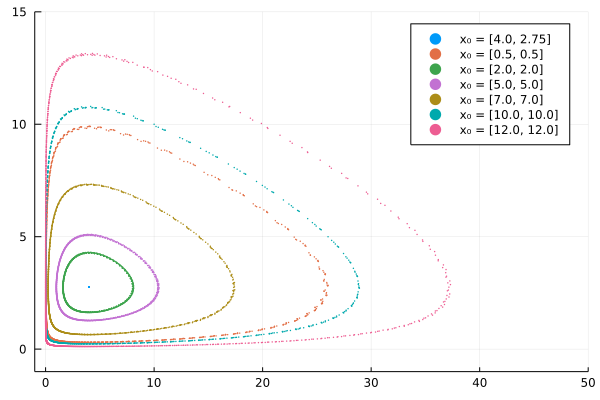

In [106]:
plot() # initialize an empty plot
for u0 in [[p[4]/p[3], p[1]/p[2]], [.5, .5], [2., 2.], [5., 5.], [7., 7.], [10., 10.], [12., 12.]]
    new_prob = remake(lv_prob, u0=u0) # remake the problem, with new initial condition
    new_sol = solve(new_prob) # find new solution
    scatter!(new_sol, vars=(1, 2), label="x₀ = $(u0)", ms=1, msw=0) # plot the new solution
end
plot!(xlims=(-1, 50), ylims=(-1, 15)) # adjust axis for better viz

From visual inspection, we can see that the model has at one stable solution in `[4.0, 2.75]`.

## Computing the solution

Euler method, Backward Euler, Range-Kuta

Implicit Euler, Newton method

## Notes about derivative

Forward AD: needed for implicit methods

Backward AD: needed for fitting the dat

## Fitting the ODE

The shooting problem, use nonlinear optimisation methods in `JuMP`, `Optim.jl` and `NLopt.jl`

$$
\begin{aligned}
L(p) = \Vert f(p) - y \Vert \\
L(p) = \sum_t \Vert f(t, p) - y_t \Vert 
\end{aligned}
$$

local vs global optimization methods

local methods boil down to gradient descent

root finding usig Newton's method, but need Hessian

alternative is BFGS, gradient based that attempts to approximate the Hessian along the way

how to efficiently compute $df/dp$?

## Backpropagation reviewed

Assume there is a **cost function** $g(x, p): N \times K ↦ \mathbb{R} $. The solution must satisfy an **arbitrary condition**, $f(x, p) = 0$. Our objective is to **find the optimal set of parameters** $p$:

$$
\hat{p} = argmin_{p} \; g(x, p) \text{ , subject to } f(x, p) = 0
$$

In **practical terms**, how do we solve this problem? **Gradient descent**.

1. Given parameters, solve the nonlinear system $f(x, p) = 0$ for $x$. If using a Newton method, you will likely need to compute $f_x$, save it for latter.
2. Compute cost $g$.
3. Change parameters in the direction of steepest descent $\frac{dg}{dp}$ to minimize. This will likely entail computing $f_x$, $g_x$, $f_p$, $g_p$. 
4. Go to 1, untill convergence.

Let's make some useful definitions:

* $\bar{x} = \frac{\partial g}{\partial x}$ represents the derivative of an intermediate variable with relation to the cost function $g$.

* let $y = f(x)$, the pullback of $f$ at $x$ is defined as $\mathcal{B}_f^x(y) = y^\top \frac{\partial f}{\partial x}(x) = y^\top \frac{\partial y}{\partial x}$. 

According to the chain rule, $\mathcal{B}_f^x(\bar{y}) = \frac{\partial g}{\partial y} \frac{\partial y}{\partial x} = \bar{x}$.

Given our condition, $f(x, p) = 0$, $x$ can be implicitly defined as a function of $p$. Thus, $x_p = -f_x^{-1} f_p$.

Let's compute direction of steepest descent:

$$
\left.{ \frac{dg}{dp} }\right|_{f = 0} = 
    \frac{\partial g}{\partial p} \frac{d p}{dp} + \frac{\partial g}{\partial x}\frac{d x}{dp} = 
    g_p + g_x x_p = 
    \bar{p} - \underbrace{\bar{x}}_{\scriptscriptstyle{1 \times N}} \, \overbrace{f_x^{-1}}^{\scriptscriptstyle{N \times N}} \underbrace{f_p}_{\scriptscriptstyle{N \times P}}
$$

As it stands, the multiplication of this an $N \times N$ matrix by an $N \times P$ matrix.

**Can we do better?**

Now, let $\lambda^\top = \bar{x} f_x^{-1} \Rightarrow \lambda^\top f_x  = \bar{x} = \mathcal{B}_f^x(\lambda)$ which is a vector-Jacobian product. 

If we know, $f_x$ and $\bar{x}$, the vector $\lambda$ can be efficiently computed as the solution to a linear system.

$$
\left.{ \frac{dg}{dp} }\right|_{f = 0} = \bar{p} - \lambda^\top f_p = \bar{p} - \mathcal{B}_f^p(\lambda)
$$

If we assume that, $y = f(x, p)$, then $\mathcal{B}_f^x(\bar{y}) = \bar{x}$. Thus, $\bar{y} = \lambda$. In other words, $\lambda$ represents the shadow cost of changing our constraint.

## An adjoint example

Assume that $f(x, p) = A x - b$, and our parameters are $p = \{A, b\}$.

The adjoint (or pullback) of $x$ is given by $\bar{x} = \mathcal{B}_f^x(\lambda) = \lambda^\top A$.

The expression $\lambda^\top f_x = g_x$ becomes $\lambda^\top A = g_x$.

In [138]:
using Zygote

In [139]:
A = rand(5, 5)
x = ones(5)
res, back = Zygote.pullback(x -> A*x, x)
back

#41 (generic function with 1 method)

In [140]:
λ = rand(5)
back(λ)

([1.01175080623616, 1.0011741984829832, 1.7109986108274962, 0.9188260934099067, 1.4406127958108232],)

In [141]:
λ'*A

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 1.01175  1.00117  1.711  0.918826  1.44061

Check [Zygote documentation](https://fluxml.ai/Zygote.jl/latest/) for more.

## Adjoint of ODE

Our previous formulation is general enough to accommodate the problem of fitting data to an ODE.

Let the ODE with law of motion $\dot{u} = f(u, p, t)$, we define the cost function as:

$$
G(u, p) = G(u(p)) = \int_0^T g(u(t, p))dt
$$

To find the derivative of the cost function with relation to the parameters, we employ a mathematical trick and add a term equal to $0$ --- remember the law of motion:

$$
I(p) = G(p) - \int_0^T \lambda^\top (\dot{u} - f(u, p, t)) dt
$$

We then compute the derivative:

$$
\frac{d G}{dp} = \int_0^T (g_u \frac{d u}{d p}) dt - \int_0^T \lambda^\top (\frac{d \dot{u}}{dt} - f_u \frac{du}{dt} - f_p) dt
$$

This expression can be reduced to the following --- see the derivation by [Chris Rackauckas](https://mitmath.github.io/18337/lecture11/adjoints):

$$
\frac{d G}{dp} = \int_0^T \lambda^\top f_p \, dt + |\lambda^\top(t) \frac{du}{dp}(t)|_0^T - \int_0^T (\dot{\lambda}^\top + \lambda^\top f_u - g_u) \frac{d u}{d p} dt
$$

We will impose the following conditions:

$$
\begin{aligned}
\dot{\lambda} &= - f_u^\top \lambda + g_u^\top = - \mathcal{B}_f^u(\lambda)^\top + \mathcal{B}_g^u(1)^\top  \\
\lambda(T) &= 0
\end{aligned}
$$

Rememeber that $\frac{d u}{d p}(0) = 0$ because of the constraint on the initial condition that $u(0) = 0$ for any parameter $p$. Thus, we arrive at the following:

$$
\frac{dG}{dp} = \int_0^T \lambda^\top f_p \, dt = \int_0^T \mathcal{B}_f^p(\lambda) \, dt
$$

This derivation gives us a recipe to optimize the parameters of the ODE:

1. solve the ODE $\dot{u} = f(u, p, t)$ forward starting from $u(0) = 0$ to obtain $u(t)$.
2. solve the ODE $\dot{\lambda} = -f_u^\top \lambda + g_u^\top$ backwards starting from $\lambda(T) = 0$ to obtain $\lambda(t)$.
3. backpropagate $\lambda$ and integrate it to find $\frac{d G}{dp}$.

## Discrete cost functions

In most cases we can only make observations at discrete points, which means we must reformulate our cost function.

$$
G(u,p) = \int_0^T\sum_{i=N}^{M} \Vert d_i - u(t_i, p) \Vert_2 \delta(t_i - t) dt = \sum_{i = 1}^N \Vert d_i - u(t_i, p) \Vert_2
$$

where $\delta(t_i - t)$ is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function).

In discrete cases, our evaluation of $\dot{\lambda}$ is as following:

$$
\dot{\lambda} = \begin{cases}
- \mathcal{B}_f^u(\lambda)^\top + \mathcal{B}_g^u(1)^\top &\text{ , if } \\
- \mathcal{B}_f^u(\lambda)^\top &\text{ , otherwise}
\end{cases}
$$

## What about the derivation in the original paper (Chen et al. 2018)?


In the original paper, the authors define by $a(t) = - \frac{\partial G}{\partial u} = - \bar{u}$ and derive the following expression:

$$
\dot{a} = - a^\top f_u
$$

## Computing the reverse ODE
$$
g_u(t) = \sum_{i = 1}^N 2(d_i - u(t, p)) \delta(t_i -t)
$$

Solve from $T$ to $t_n$. At instantaneous point we add a value, You change $\lambda$ by $g_u$. Then integrate $\lambda$ to $t_{n-1}$. Then change by $g_u(t_{n-1})$.

How do you compute the reverse ODE?

1. first option: interpolating adjoint method

$$
\frac{d\lambda}{dt} = -\lambda \frac{f}{du(t)} - \frac{g}{du(t)}
$$

The Jacoabian of $f(u(t), p, t)$ at the point $u(t)$. Solve forward for ODE solver that gives you a continuous solution and then take the Jacobina on the solution.

2. solve in reverse: backsolve method

$$
\dot{u} = -f(u, p, -t)
\dot{\lambda} = -\lambda f_u + g_u
$$

3. this is backpropagation

$$
\lambda^\top f_u = \mathcal{B}^{u(t)}_f(\lambda^\top) \Rightarrow \dot{\lambda} = - \mathcal{B}^{u(t)}_f(\lambda^\top)
$$

The $\lambda$ is the solution to the $ODE$ by using backpropagation.

What's the equivalent of defining a backpropagation. You solve the ODE forward, then you solve the ODE defined by backpropagation going backwards, then perform the integral

$$
\begin{cases}
\dot{u} &= - f(u, p, -t) \\
\dot{\lambda}^\top &= - \mathcal{B}_f^{u(t)}(\lambda^\top) + g_u \\
\dot{\mu} &= \lambda^\top f_p + g_p  = \mathcal{B}_f^{p}(\lambda^\top) + g_p
\end{cases}
$$

with the conditions that $\lambda^\top = 0$ and $\mu(T) = 0$. Then $\mu(0) = \frac{dG}{dp}$.

# NeuralODE

**The initial value problem reviewed, fitting data to ODEs with machine learning**

# Exercises

# References

John Doe